In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=1

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200606, 2) (50134, 2)
train/valid # (200606, 2) (50134, 2)
rand split across time
train has 200606 records out of 389630 records
valid has 50134 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1567
0
(200606, 1, 36) (200606, 7, 32) (200606, 1) (200606, 1)
(200606, 260) (200606,) (200606,)
(50134, 1, 36) (50134, 7, 32) (50134, 1) (50134, 1)
(50134, 260) (50134,) (50134,)
(5803, 1, 36) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 260) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4015	valid-rmse:2.36301
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985183	valid-rmse:0.979008
[100]	train-rmse:0.572373	valid-rmse:0.586693
[150]	train-rmse:0.487218	valid-rmse:0.512221
[200]	train-rmse:0.470724	valid-rmse:0.501324
[250]	train-rmse:0.465241	valid-rmse:0.499784
[300]	train-rmse:0.461396	valid-rmse:0.499536
[350]	train-rmse:0.458767	valid-rmse:0.49955
Stopping. Best iteration:
[326]	train-rmse:0.45981	valid-rmse:0.499527

0.21142566 0.24952774
[0.24952774]
-1 mean score 0.24952774
0.191352441907


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924461  0.004649  0.199066    7  2017-04-16
472     2.507290  2.531603 -0.024313  0.208435    1  2017-04-17
473     2.661330  2.663003 -0.001673  0.221339    2  2017-04-18
474     2.754815  2.741683  0.013131  0.184699    3  2017-04-19
475     2.713762  2.710616  0.003146  0.212677    4  2017-04-20
476     2.999000  2.978732  0.020268  0.145013    5  2017-04-21
477     3.075529  3.076975 -0.001446  0.168236    6  2017-04-22

0.191352441907


pred         y     error    error2  day        date
dayidx                                                         
471     2.924461  2.929110  0.004649  0.199066    7  2017-04-16
472     2.531603  2.507290 -0.024313  0.208435    1  2017-04-17
473     2.663003  2.661330 -0.001673  0.221339    2  2017-04-18
474     2.741683  2.754815  0.013131  0.184699    3  2017-04-19
475     2.710616  2.713762  0.003146  0.212677    4  2017-04-20
476     2.978732  2.999000  0.020268  0.145013    5  2017-04-21
477     3.076975  3.075529 -0.001446  0.168236    6  2017-04-22

(829, 260)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200381, 2) (50076, 2)
train/valid # (200381, 2) (50076, 2)
rand split across time
train has 200381 records out of 389630 records
valid has 50076 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200381, 1, 36) (200381, 7, 32) (200381, 1) (200381, 1)
(200381, 260) (200381,) (200381,)
(50076, 1, 36) (50076, 7, 32) (50076, 1) (50076, 1)
(50076, 260) (50076,) (50076,)
(6632, 1, 36) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 260) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40132	valid-rmse:2.36269
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987756	valid-rmse:0.97882
[100]	train-rmse:0.577517	valid-rmse:0.589427
[150]	train-rmse:0.493431	valid-rmse:0.517226
[200]	train-rmse:0.477279	valid-rmse:0.507404
[250]	train-rmse:0.472211	valid-rmse:0.506276
[300]	train-rmse:0.469006	valid-rmse:0.506275
Stopping. Best iteration:
[268]	train-rmse:0.470915	valid-rmse:0.506232

0.22176054 0.25627065
[0.25627065]
-1 mean score 0.25627065
0.198189049959


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913675  0.015435  0.211690    7  2017-04-16
472     2.507290  2.528350 -0.021059  0.215804    1  2017-04-17
473     2.661330  2.650754  0.010575  0.226415    2  2017-04-18
474     2.754815  2.733126  0.021689  0.194618    3  2017-04-19
475     2.713762  2.710280  0.003482  0.222150    4  2017-04-20
476     2.999000  2.982201  0.016799  0.148008    5  2017-04-21
477     3.075529  3.059927  0.015602  0.168638    6  2017-04-22

0.198189049959


pred         y     error    error2  day        date
dayidx                                                         
471     2.913675  2.929110  0.015435  0.211690    7  2017-04-16
472     2.528350  2.507290 -0.021059  0.215804    1  2017-04-17
473     2.650754  2.661330  0.010575  0.226415    2  2017-04-18
474     2.733126  2.754815  0.021689  0.194618    3  2017-04-19
475     2.710280  2.713762  0.003482  0.222150    4  2017-04-20
476     2.982201  2.999000  0.016799  0.148008    5  2017-04-21
477     3.059927  3.075529  0.015602  0.168638    6  2017-04-22

(829, 260)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200200, 2) (50030, 2)
train/valid # (200200, 2) (50030, 2)
rand split across time
train has 200200 records out of 389630 records
valid has 50030 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1564
0
(200200, 1, 36) (200200, 7, 32) (200200, 1) (200200, 1)
(200200, 260) (200200,) (200200,)
(50030, 1, 36) (50030, 7, 32) (50030, 1) (50030, 1)
(50030, 260) (50030,) (50030,)
(7461, 1, 36) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 260) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40112	valid-rmse:2.36245
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988755	valid-rmse:0.982571
[100]	train-rmse:0.579367	valid-rmse:0.593084
[150]	train-rmse:0.495568	valid-rmse:0.519489
[200]	train-rmse:0.479506	valid-rmse:0.508829
[250]	train-rmse:0.473985	valid-rmse:0.507303
[300]	train-rmse:0.470423	valid-rmse:0.507168
[350]	train-rmse:0.467139	valid-rmse:0.507128
Stopping. Best iteration:
[342]	train-rmse:0.467693	valid-rmse:0.507111

0.21873662 0.25716183
[0.25716183]
-1 mean score 0.25716183
0.197327047586


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903448  0.025662  0.206403    7  2017-04-16
472     2.507290  2.532476 -0.025185  0.213673    1  2017-04-17
473     2.661330  2.645325  0.016004  0.234771    2  2017-04-18
474     2.754815  2.749856  0.004959  0.191801    3  2017-04-19
475     2.713762  2.711764  0.001998  0.222407    4  2017-04-20
476     2.999000  2.988381  0.010618  0.146217    5  2017-04-21
477     3.075529  3.065812  0.009717  0.166017    6  2017-04-22

0.197327047586


pred         y     error    error2  day        date
dayidx                                                         
471     2.903448  2.929110  0.025662  0.206403    7  2017-04-16
472     2.532476  2.507290 -0.025185  0.213673    1  2017-04-17
473     2.645325  2.661330  0.016004  0.234771    2  2017-04-18
474     2.749856  2.754815  0.004959  0.191801    3  2017-04-19
475     2.711764  2.713762  0.001998  0.222407    4  2017-04-20
476     2.988381  2.999000  0.010618  0.146217    5  2017-04-21
477     3.065812  3.075529  0.009717  0.166017    6  2017-04-22

(829, 260)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200042, 2) (49986, 2)
train/valid # (200042, 2) (49986, 2)
rand split across time
train has 200042 records out of 389630 records
valid has 49986 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200042, 1, 36) (200042, 7, 32) (200042, 1) (200042, 1)
(200042, 260) (200042,) (200042,)
(49986, 1, 36) (49986, 7, 32) (49986, 1) (49986, 1)
(49986, 260) (49986,) (49986,)
(8290, 1, 36) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 260) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40112	valid-rmse:2.36238
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989279	valid-rmse:0.979145
[100]	train-rmse:0.580559	valid-rmse:0.591124
[150]	train-rmse:0.496991	valid-rmse:0.519957
[200]	train-rmse:0.480922	valid-rmse:0.510433
[250]	train-rmse:0.475364	valid-rmse:0.509454
[300]	train-rmse:0.471834	valid-rmse:0.509466
Stopping. Best iteration:
[272]	train-rmse:0.473688	valid-rmse:0.509421

0.22438005 0.25951004
[0.25951004]
-1 mean score 0.25951004
0.201339930296


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898435  0.030675  0.213564    7  2017-04-16
472     2.507290  2.520390 -0.013100  0.220619    1  2017-04-17
473     2.661330  2.633666  0.027664  0.235195    2  2017-04-18
474     2.754815  2.732714  0.022101  0.196918    3  2017-04-19
475     2.713762  2.708484  0.005278  0.221640    4  2017-04-20
476     2.999000  2.972480  0.026520  0.152523    5  2017-04-21
477     3.075529  3.060922  0.014607  0.168921    6  2017-04-22

0.201339930296


pred         y     error    error2  day        date
dayidx                                                         
471     2.898435  2.929110  0.030675  0.213564    7  2017-04-16
472     2.520390  2.507290 -0.013100  0.220619    1  2017-04-17
473     2.633666  2.661330  0.027664  0.235195    2  2017-04-18
474     2.732714  2.754815  0.022101  0.196918    3  2017-04-19
475     2.708484  2.713762  0.005278  0.221640    4  2017-04-20
476     2.972480  2.999000  0.026520  0.152523    5  2017-04-21
477     3.060922  3.075529  0.014607  0.168921    6  2017-04-22

(829, 260)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199839, 2) (49937, 2)
train/valid # (199839, 2) (49937, 2)
rand split across time
train has 199839 records out of 389630 records
valid has 49937 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0
(199839, 1, 36) (199839, 7, 32) (199839, 1) (199839, 1)
(199839, 260) (199839,) (199839,)
(49937, 1, 36) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 260) (49937,) (49937,)
(9119, 1, 36) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 260) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40134	valid-rmse:2.36273
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990144	valid-rmse:0.9851
[100]	train-rmse:0.582035	valid-rmse:0.596954
[150]	train-rmse:0.498638	valid-rmse:0.523455
[200]	train-rmse:0.482689	valid-rmse:0.51267
[250]	train-rmse:0.477572	valid-rmse:0.511155
[300]	train-rmse:0.474059	valid-rmse:0.511056
Stopping. Best iteration:
[288]	train-rmse:0.474753	valid-rmse:0.511032

0.22539058 0.2611541
[0.2611541]
-1 mean score 0.2611541
0.202588483691


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899960  0.029150  0.211621    7  2017-04-16
472     2.507290  2.525100 -0.017809  0.222679    1  2017-04-17
473     2.661330  2.624369  0.036960  0.238540    2  2017-04-18
474     2.754815  2.729839  0.024976  0.196030    3  2017-04-19
475     2.713762  2.704146  0.009615  0.225323    4  2017-04-20
476     2.999000  2.969385  0.029614  0.153369    5  2017-04-21
477     3.075529  3.059652  0.015878  0.170557    6  2017-04-22

0.202588483691


pred         y     error    error2  day        date
dayidx                                                         
471     2.899960  2.929110  0.029150  0.211621    7  2017-04-16
472     2.525100  2.507290 -0.017809  0.222679    1  2017-04-17
473     2.624369  2.661330  0.036960  0.238540    2  2017-04-18
474     2.729839  2.754815  0.024976  0.196030    3  2017-04-19
475     2.704146  2.713762  0.009615  0.225323    4  2017-04-20
476     2.969385  2.999000  0.029614  0.153369    5  2017-04-21
477     3.059652  3.075529  0.015878  0.170557    6  2017-04-22

(829, 260)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199631, 2) (49882, 2)
train/valid # (199631, 2) (49882, 2)
rand split across time
train has 199631 records out of 389630 records
valid has 49882 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199631, 1, 36) (199631, 7, 32) (199631, 1) (199631, 1)
(199631, 260) (199631,) (199631,)
(49882, 1, 36) (49882, 7, 32) (49882, 1) (49882, 1)
(49882, 260) (49882,) (49882,)
(9948, 1, 36) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 260) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40152	valid-rmse:2.3628
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990608	valid-rmse:0.983436
[100]	train-rmse:0.582869	valid-rmse:0.59611
[150]	train-rmse:0.499736	valid-rmse:0.52404
[200]	train-rmse:0.48378	valid-rmse:0.514029
[250]	train-rmse:0.47869	valid-rmse:0.512764
[300]	train-rmse:0.474971	valid-rmse:0.512666
Stopping. Best iteration:
[276]	train-rmse:0.476548	valid-rmse:0.512657

0.2270982 0.26281756
[0.26281756]
-1 mean score 0.26281756
0.206580653787


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909576  0.019534  0.221714    7  2017-04-16
472     2.507290  2.536774 -0.029483  0.230892    1  2017-04-17
473     2.661330  2.630743  0.030587  0.243105    2  2017-04-18
474     2.754815  2.726771  0.028044  0.199198    3  2017-04-19
475     2.713762  2.710678  0.003084  0.227961    4  2017-04-20
476     2.999000  2.963397  0.035603  0.153110    5  2017-04-21
477     3.075529  3.072664  0.002865  0.170084    6  2017-04-22

0.206580653787


pred         y     error    error2  day        date
dayidx                                                         
471     2.909576  2.929110  0.019534  0.221714    7  2017-04-16
472     2.536774  2.507290 -0.029483  0.230892    1  2017-04-17
473     2.630743  2.661330  0.030587  0.243105    2  2017-04-18
474     2.726771  2.754815  0.028044  0.199198    3  2017-04-19
475     2.710678  2.713762  0.003084  0.227961    4  2017-04-20
476     2.963397  2.999000  0.035603  0.153110    5  2017-04-21
477     3.072664  3.075529  0.002865  0.170084    6  2017-04-22

(829, 260)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199412, 2) (49827, 2)
train/valid # (199412, 2) (49827, 2)
rand split across time
train has 199412 records out of 389630 records
valid has 49827 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199412, 1, 36) (199412, 7, 32) (199412, 1) (199412, 1)
(199412, 260) (199412,) (199412,)
(49827, 1, 36) (49827, 7, 32) (49827, 1) (49827, 1)
(49827, 260) (49827,) (49827,)
(10777, 1, 36) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 260) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40163	valid-rmse:2.36306
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991455	valid-rmse:0.983375
[100]	train-rmse:0.584379	valid-rmse:0.596973
[150]	train-rmse:0.501549	valid-rmse:0.525433
[200]	train-rmse:0.485597	valid-rmse:0.51558
[250]	train-rmse:0.480089	valid-rmse:0.514416
[300]	train-rmse:0.476588	valid-rmse:0.514334
Stopping. Best iteration:
[289]	train-rmse:0.477263	valid-rmse:0.51432

0.22777978 0.26452526
[0.26452526]
-1 mean score 0.26452526
0.206922650337


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908954  0.020156  0.217210    7  2017-04-16
472     2.507290  2.548772 -0.041481  0.231916    1  2017-04-17
473     2.661330  2.637643  0.023686  0.244646    2  2017-04-18
474     2.754815  2.725548  0.029266  0.200892    3  2017-04-19
475     2.713762  2.708465  0.005297  0.227445    4  2017-04-20
476     2.999000  2.974108  0.024892  0.150645    5  2017-04-21
477     3.075529  3.084566 -0.009037  0.175704    6  2017-04-22

0.206922650337


pred         y     error    error2  day        date
dayidx                                                         
471     2.908954  2.929110  0.020156  0.217210    7  2017-04-16
472     2.548772  2.507290 -0.041481  0.231916    1  2017-04-17
473     2.637643  2.661330  0.023686  0.244646    2  2017-04-18
474     2.725548  2.754815  0.029266  0.200892    3  2017-04-19
475     2.708465  2.713762  0.005297  0.227445    4  2017-04-20
476     2.974108  2.999000  0.024892  0.150645    5  2017-04-21
477     3.084566  3.075529 -0.009037  0.175704    6  2017-04-22

(829, 260)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199179, 2) (49770, 2)
train/valid # (199179, 2) (49770, 2)
rand split across time
train has 199179 records out of 389630 records
valid has 49770 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1556
0
(199179, 1, 36) (199179, 7, 32) (199179, 1) (199179, 1)
(199179, 260) (199179,) (199179,)
(49770, 1, 36) (49770, 7, 32) (49770, 1) (49770, 1)
(49770, 260) (49770,) (49770,)
(11606, 1, 36) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 260) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40153	valid-rmse:2.36292
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992909	valid-rmse:0.988127
[100]	train-rmse:0.586949	valid-rmse:0.602891
[150]	train-rmse:0.504438	valid-rmse:0.530592
[200]	train-rmse:0.488653	valid-rmse:0.520124
[250]	train-rmse:0.483249	valid-rmse:0.518673
[300]	train-rmse:0.479486	valid-rmse:0.518614
Stopping. Best iteration:
[281]	train-rmse:0.48078	valid-rmse:0.518588

0.23114975 0.268934
[0.268934]
-1 mean score 0.268934
0.212462320924


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918638  0.010472  0.230838    7  2017-04-16
472     2.507290  2.543768 -0.036478  0.231088    1  2017-04-17
473     2.661330  2.643500  0.017830  0.248980    2  2017-04-18
474     2.754815  2.729253  0.025562  0.209738    3  2017-04-19
475     2.713762  2.706007  0.007755  0.232181    4  2017-04-20
476     2.999000  2.960803  0.038197  0.159280    5  2017-04-21
477     3.075529  3.080169 -0.004640  0.175131    6  2017-04-22

0.212462320924


pred         y     error    error2  day        date
dayidx                                                         
471     2.918638  2.929110  0.010472  0.230838    7  2017-04-16
472     2.543768  2.507290 -0.036478  0.231088    1  2017-04-17
473     2.643500  2.661330  0.017830  0.248980    2  2017-04-18
474     2.729253  2.754815  0.025562  0.209738    3  2017-04-19
475     2.706007  2.713762  0.007755  0.232181    4  2017-04-20
476     2.960803  2.999000  0.038197  0.159280    5  2017-04-21
477     3.080169  3.075529 -0.004640  0.175131    6  2017-04-22

(829, 260)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198954, 2) (49713, 2)
train/valid # (198954, 2) (49713, 2)
rand split across time
train has 198954 records out of 389630 records
valid has 49713 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1554
0
(198954, 1, 36) (198954, 7, 32) (198954, 1) (198954, 1)
(198954, 260) (198954,) (198954,)
(49713, 1, 36) (49713, 7, 32) (49713, 1) (49713, 1)
(49713, 260) (49713,) (49713,)
(12435, 1, 36) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 260) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40125	valid-rmse:2.36253
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99391	valid-rmse:0.988205
[100]	train-rmse:0.588966	valid-rmse:0.604034
[150]	train-rmse:0.506555	valid-rmse:0.532432
[200]	train-rmse:0.490368	valid-rmse:0.522177
[250]	train-rmse:0.485071	valid-rmse:0.520805
[300]	train-rmse:0.480766	valid-rmse:0.520698
Stopping. Best iteration:
[281]	train-rmse:0.482266	valid-rmse:0.52066

0.2325802 0.27108693
[0.27108693]
-1 mean score 0.27108693
0.212388664484


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916718  0.012391  0.229442    7  2017-04-16
472     2.507290  2.552893 -0.045602  0.227803    1  2017-04-17
473     2.661330  2.657381  0.003949  0.251086    2  2017-04-18
474     2.754815  2.725113  0.029702  0.212179    3  2017-04-19
475     2.713762  2.708531  0.005231  0.230727    4  2017-04-20
476     2.999000  2.961108  0.037891  0.161962    5  2017-04-21
477     3.075529  3.073243  0.002287  0.173522    6  2017-04-22

0.212388664484


pred         y     error    error2  day        date
dayidx                                                         
471     2.916718  2.929110  0.012391  0.229442    7  2017-04-16
472     2.552893  2.507290 -0.045602  0.227803    1  2017-04-17
473     2.657381  2.661330  0.003949  0.251086    2  2017-04-18
474     2.725113  2.754815  0.029702  0.212179    3  2017-04-19
475     2.708531  2.713762  0.005231  0.230727    4  2017-04-20
476     2.961108  2.999000  0.037891  0.161962    5  2017-04-21
477     3.073243  3.075529  0.002287  0.173522    6  2017-04-22

(829, 260)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198785, 2) (49666, 2)
train/valid # (198785, 2) (49666, 2)
rand split across time
train has 198785 records out of 389630 records
valid has 49666 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1553
0
(198785, 1, 36) (198785, 7, 32) (198785, 1) (198785, 1)
(198785, 260) (198785,) (198785,)
(49666, 1, 36) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 260) (49666,) (49666,)
(13264, 1, 36) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 260) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40124	valid-rmse:2.36245
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99437	valid-rmse:0.988338
[100]	train-rmse:0.589792	valid-rmse:0.604213
[150]	train-rmse:0.50756	valid-rmse:0.532677
[200]	train-rmse:0.491417	valid-rmse:0.522474
[250]	train-rmse:0.486112	valid-rmse:0.52121
[300]	train-rmse:0.481775	valid-rmse:0.521125
Stopping. Best iteration:
[278]	train-rmse:0.483581	valid-rmse:0.521102

0.23385017 0.27154768
[0.27154768]
-1 mean score 0.27154768
0.212069749832


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910460  0.018650  0.227004    7  2017-04-16
472     2.507290  2.538118 -0.030828  0.227058    1  2017-04-17
473     2.661330  2.659448  0.001882  0.253930    2  2017-04-18
474     2.754815  2.733139  0.021676  0.210435    3  2017-04-19
475     2.713762  2.712981  0.000780  0.230850    4  2017-04-20
476     2.999000  2.964454  0.034546  0.161743    5  2017-04-21
477     3.075529  3.076130 -0.000601  0.173469    6  2017-04-22

0.212069749832


pred         y     error    error2  day        date
dayidx                                                         
471     2.910460  2.929110  0.018650  0.227004    7  2017-04-16
472     2.538118  2.507290 -0.030828  0.227058    1  2017-04-17
473     2.659448  2.661330  0.001882  0.253930    2  2017-04-18
474     2.733139  2.754815  0.021676  0.210435    3  2017-04-19
475     2.712981  2.713762  0.000780  0.230850    4  2017-04-20
476     2.964454  2.999000  0.034546  0.161743    5  2017-04-21
477     3.076130  3.075529 -0.000601  0.173469    6  2017-04-22

(829, 260)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198605, 2) (49620, 2)
train/valid # (198605, 2) (49620, 2)
rand split across time
train has 198605 records out of 389630 records
valid has 49620 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198605, 1, 36) (198605, 7, 32) (198605, 1) (198605, 1)
(198605, 260) (198605,) (198605,)
(49620, 1, 36) (49620, 7, 32) (49620, 1) (49620, 1)
(49620, 260) (49620,) (49620,)
(14093, 1, 36) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 260) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40152	valid-rmse:2.36277
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994833	valid-rmse:0.989043
[100]	train-rmse:0.590686	valid-rmse:0.605118
[150]	train-rmse:0.508437	valid-rmse:0.533715
[200]	train-rmse:0.492186	valid-rmse:0.523516
[250]	train-rmse:0.486775	valid-rmse:0.52226
[300]	train-rmse:0.482277	valid-rmse:0.52225
Stopping. Best iteration:
[278]	train-rmse:0.484228	valid-rmse:0.522202

0.23447701 0.2726946
[0.2726946]
-1 mean score 0.2726946
0.212193727493


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901337  0.027773  0.225537    7  2017-04-16
472     2.507290  2.539559 -0.032268  0.227477    1  2017-04-17
473     2.661330  2.653293  0.008037  0.256223    2  2017-04-18
474     2.754815  2.720713  0.034102  0.209099    3  2017-04-19
475     2.713762  2.721517 -0.007756  0.230017    4  2017-04-20
476     2.999000  2.969624  0.029376  0.162336    5  2017-04-21
477     3.075529  3.061975  0.013554  0.174667    6  2017-04-22

0.212193727493


pred         y     error    error2  day        date
dayidx                                                         
471     2.901337  2.929110  0.027773  0.225537    7  2017-04-16
472     2.539559  2.507290 -0.032268  0.227477    1  2017-04-17
473     2.653293  2.661330  0.008037  0.256223    2  2017-04-18
474     2.720713  2.754815  0.034102  0.209099    3  2017-04-19
475     2.721517  2.713762 -0.007756  0.230017    4  2017-04-20
476     2.969624  2.999000  0.029376  0.162336    5  2017-04-21
477     3.061975  3.075529  0.013554  0.174667    6  2017-04-22

(829, 260)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198392, 2) (49566, 2)
train/valid # (198392, 2) (49566, 2)
rand split across time
train has 198392 records out of 389630 records
valid has 49566 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198392, 1, 36) (198392, 7, 32) (198392, 1) (198392, 1)
(198392, 260) (198392,) (198392,)
(49566, 1, 36) (49566, 7, 32) (49566, 1) (49566, 1)
(49566, 260) (49566,) (49566,)
(14922, 1, 36) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 260) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40176	valid-rmse:2.36291
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995424	valid-rmse:0.989329
[100]	train-rmse:0.59154	valid-rmse:0.606367
[150]	train-rmse:0.509462	valid-rmse:0.535363
[200]	train-rmse:0.493664	valid-rmse:0.525301
[250]	train-rmse:0.488148	valid-rmse:0.524006
[300]	train-rmse:0.48405	valid-rmse:0.524014
Stopping. Best iteration:
[251]	train-rmse:0.488107	valid-rmse:0.523993

0.23824868 0.27456918
[0.27456918]
-1 mean score 0.27456918
0.21708612144


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890987  0.038123  0.237322    7  2017-04-16
472     2.507290  2.537968 -0.030677  0.229291    1  2017-04-17
473     2.661330  2.651379  0.009951  0.261217    2  2017-04-18
474     2.754815  2.712865  0.041950  0.218059    3  2017-04-19
475     2.713762  2.706891  0.006870  0.232595    4  2017-04-20
476     2.999000  2.959419  0.039580  0.165660    5  2017-04-21
477     3.075529  3.059496  0.016033  0.175460    6  2017-04-22

0.21708612144


pred         y     error    error2  day        date
dayidx                                                         
471     2.890987  2.929110  0.038123  0.237322    7  2017-04-16
472     2.537968  2.507290 -0.030677  0.229291    1  2017-04-17
473     2.651379  2.661330  0.009951  0.261217    2  2017-04-18
474     2.712865  2.754815  0.041950  0.218059    3  2017-04-19
475     2.706891  2.713762  0.006870  0.232595    4  2017-04-20
476     2.959419  2.999000  0.039580  0.165660    5  2017-04-21
477     3.059496  3.075529  0.016033  0.175460    6  2017-04-22

(829, 260)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198182, 2) (49513, 2)
train/valid # (198182, 2) (49513, 2)
rand split across time
train has 198182 records out of 389630 records
valid has 49513 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1548
0
(198182, 1, 36) (198182, 7, 32) (198182, 1) (198182, 1)
(198182, 260) (198182,) (198182,)
(49513, 1, 36) (49513, 7, 32) (49513, 1) (49513, 1)
(49513, 260) (49513,) (49513,)
(15751, 1, 36) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 260) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40185	valid-rmse:2.36314
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995787	valid-rmse:0.989017
[100]	train-rmse:0.592145	valid-rmse:0.606229
[150]	train-rmse:0.51007	valid-rmse:0.535547
[200]	train-rmse:0.494137	valid-rmse:0.525749
[250]	train-rmse:0.488498	valid-rmse:0.524592
[300]	train-rmse:0.484623	valid-rmse:0.524589
Stopping. Best iteration:
[257]	train-rmse:0.48788	valid-rmse:0.524556

0.23802742 0.2751592
[0.2751592]
-1 mean score 0.2751592
0.215683311224


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898695  0.030415  0.231775    7  2017-04-16
472     2.507290  2.537953 -0.030663  0.232940    1  2017-04-17
473     2.661330  2.656474  0.004855  0.255343    2  2017-04-18
474     2.754815  2.719423  0.035392  0.217018    3  2017-04-19
475     2.713762  2.714238 -0.000476  0.232948    4  2017-04-20
476     2.999000  2.969398  0.029602  0.163132    5  2017-04-21
477     3.075529  3.056701  0.018828  0.176628    6  2017-04-22

0.215683311224


pred         y     error    error2  day        date
dayidx                                                         
471     2.898695  2.929110  0.030415  0.231775    7  2017-04-16
472     2.537953  2.507290 -0.030663  0.232940    1  2017-04-17
473     2.656474  2.661330  0.004855  0.255343    2  2017-04-18
474     2.719423  2.754815  0.035392  0.217018    3  2017-04-19
475     2.714238  2.713762 -0.000476  0.232948    4  2017-04-20
476     2.969398  2.999000  0.029602  0.163132    5  2017-04-21
477     3.056701  3.075529  0.018828  0.176628    6  2017-04-22

(829, 260)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197959, 2) (49458, 2)
train/valid # (197959, 2) (49458, 2)
rand split across time
train has 197959 records out of 389630 records
valid has 49458 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197959, 1, 36) (197959, 7, 32) (197959, 1) (197959, 1)
(197959, 260) (197959,) (197959,)
(49458, 1, 36) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 260) (49458,) (49458,)
(16580, 1, 36) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 260) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40192	valid-rmse:2.3632
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996331	valid-rmse:0.990705
[100]	train-rmse:0.593212	valid-rmse:0.607964
[150]	train-rmse:0.511281	valid-rmse:0.536792
[200]	train-rmse:0.495181	valid-rmse:0.526602
[250]	train-rmse:0.489781	valid-rmse:0.52526
[300]	train-rmse:0.485891	valid-rmse:0.52522
Stopping. Best iteration:
[276]	train-rmse:0.487706	valid-rmse:0.525162

0.2378575 0.27579486
[0.27579486]
-1 mean score 0.27579486
0.214922979474


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895217  0.033893  0.236899    7  2017-04-16
472     2.507290  2.537206 -0.029916  0.228370    1  2017-04-17
473     2.661330  2.654420  0.006910  0.258608    2  2017-04-18
474     2.754815  2.717060  0.037754  0.219769    3  2017-04-19
475     2.713762  2.714243 -0.000482  0.229040    4  2017-04-20
476     2.999000  2.981808  0.017192  0.156372    5  2017-04-21
477     3.075529  3.066996  0.008533  0.175403    6  2017-04-22

0.214922979474


pred         y     error    error2  day        date
dayidx                                                         
471     2.895217  2.929110  0.033893  0.236899    7  2017-04-16
472     2.537206  2.507290 -0.029916  0.228370    1  2017-04-17
473     2.654420  2.661330  0.006910  0.258608    2  2017-04-18
474     2.717060  2.754815  0.037754  0.219769    3  2017-04-19
475     2.714243  2.713762 -0.000482  0.229040    4  2017-04-20
476     2.981808  2.999000  0.017192  0.156372    5  2017-04-21
477     3.066996  3.075529  0.008533  0.175403    6  2017-04-22

(829, 260)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197725, 2) (49402, 2)
train/valid # (197725, 2) (49402, 2)
rand split across time
train has 197725 records out of 389630 records
valid has 49402 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197725, 1, 36) (197725, 7, 32) (197725, 1) (197725, 1)
(197725, 260) (197725,) (197725,)
(49402, 1, 36) (49402, 7, 32) (49402, 1) (49402, 1)
(49402, 260) (49402,) (49402,)
(17409, 1, 36) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 260) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40182	valid-rmse:2.36296
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997732	valid-rmse:0.991413
[100]	train-rmse:0.59572	valid-rmse:0.609869
[150]	train-rmse:0.514413	valid-rmse:0.539329
[200]	train-rmse:0.498577	valid-rmse:0.529364
[250]	train-rmse:0.493216	valid-rmse:0.528107
[300]	train-rmse:0.489611	valid-rmse:0.528021
Stopping. Best iteration:
[282]	train-rmse:0.490773	valid-rmse:0.528015

0.2408586 0.27879965
[0.27879965]
-1 mean score 0.27879965
0.219862490892


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908980  0.020130  0.241694    7  2017-04-16
472     2.507290  2.542413 -0.035122  0.234253    1  2017-04-17
473     2.661330  2.649903  0.011426  0.269437    2  2017-04-18
474     2.754815  2.717861  0.036953  0.217191    3  2017-04-19
475     2.713762  2.720027 -0.006266  0.236637    4  2017-04-20
476     2.999000  2.982704  0.016295  0.162459    5  2017-04-21
477     3.075529  3.064643  0.010886  0.177366    6  2017-04-22

0.219862490892


pred         y     error    error2  day        date
dayidx                                                         
471     2.908980  2.929110  0.020130  0.241694    7  2017-04-16
472     2.542413  2.507290 -0.035122  0.234253    1  2017-04-17
473     2.649903  2.661330  0.011426  0.269437    2  2017-04-18
474     2.717861  2.754815  0.036953  0.217191    3  2017-04-19
475     2.720027  2.713762 -0.006266  0.236637    4  2017-04-20
476     2.982704  2.999000  0.016295  0.162459    5  2017-04-21
477     3.064643  3.075529  0.010886  0.177366    6  2017-04-22

(829, 260)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197493, 2) (49345, 2)
train/valid # (197493, 2) (49345, 2)
rand split across time
train has 197493 records out of 389630 records
valid has 49345 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197493, 1, 36) (197493, 7, 32) (197493, 1) (197493, 1)
(197493, 260) (197493,) (197493,)
(49345, 1, 36) (49345, 7, 32) (49345, 1) (49345, 1)
(49345, 260) (49345,) (49345,)
(18238, 1, 36) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 260) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40161	valid-rmse:2.36271
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998491	valid-rmse:0.990456
[100]	train-rmse:0.597423	valid-rmse:0.610593
[150]	train-rmse:0.516265	valid-rmse:0.541235
[200]	train-rmse:0.500133	valid-rmse:0.531705
[250]	train-rmse:0.494375	valid-rmse:0.530699
[300]	train-rmse:0.490664	valid-rmse:0.53072
Stopping. Best iteration:
[259]	train-rmse:0.493644	valid-rmse:0.530649

0.24368468 0.281588
[0.281588]
-1 mean score 0.281588
0.219855830073


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897934  0.031176  0.241106    7  2017-04-16
472     2.507290  2.542518 -0.035228  0.235471    1  2017-04-17
473     2.661330  2.640368  0.020962  0.262353    2  2017-04-18
474     2.754815  2.704182  0.050633  0.218008    3  2017-04-19
475     2.713762  2.714686 -0.000924  0.238787    4  2017-04-20
476     2.999000  2.974979  0.024021  0.164766    5  2017-04-21
477     3.075529  3.054280  0.021249  0.178499    6  2017-04-22

0.219855830073


pred         y     error    error2  day        date
dayidx                                                         
471     2.897934  2.929110  0.031176  0.241106    7  2017-04-16
472     2.542518  2.507290 -0.035228  0.235471    1  2017-04-17
473     2.640368  2.661330  0.020962  0.262353    2  2017-04-18
474     2.704182  2.754815  0.050633  0.218008    3  2017-04-19
475     2.714686  2.713762 -0.000924  0.238787    4  2017-04-20
476     2.974979  2.999000  0.024021  0.164766    5  2017-04-21
477     3.054280  3.075529  0.021249  0.178499    6  2017-04-22

(829, 260)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197331, 2) (49305, 2)
train/valid # (197331, 2) (49305, 2)
rand split across time
train has 197331 records out of 389630 records
valid has 49305 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197331, 1, 36) (197331, 7, 32) (197331, 1) (197331, 1)
(197331, 260) (197331,) (197331,)
(49305, 1, 36) (49305, 7, 32) (49305, 1) (49305, 1)
(49305, 260) (49305,) (49305,)
(19067, 1, 36) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 260) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40165	valid-rmse:2.36263
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99884	valid-rmse:0.995567
[100]	train-rmse:0.597777	valid-rmse:0.614801
[150]	train-rmse:0.51664	valid-rmse:0.543324
[200]	train-rmse:0.50047	valid-rmse:0.532687
[250]	train-rmse:0.494833	valid-rmse:0.531304
[300]	train-rmse:0.49028	valid-rmse:0.531221
Stopping. Best iteration:
[286]	train-rmse:0.491467	valid-rmse:0.531208

0.2415397 0.28218195
[0.28218195]
-1 mean score 0.28218195
0.220618963242


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905777  0.023334  0.235600    7  2017-04-16
472     2.507290  2.527783 -0.020492  0.232987    1  2017-04-17
473     2.661330  2.635704  0.025626  0.268449    2  2017-04-18
474     2.754815  2.710295  0.044519  0.222775    3  2017-04-19
475     2.713762  2.712786  0.000975  0.237920    4  2017-04-20
476     2.999000  2.982874  0.016126  0.167135    5  2017-04-21
477     3.075529  3.054674  0.020855  0.179466    6  2017-04-22

0.220618963242


pred         y     error    error2  day        date
dayidx                                                         
471     2.905777  2.929110  0.023334  0.235600    7  2017-04-16
472     2.527783  2.507290 -0.020492  0.232987    1  2017-04-17
473     2.635704  2.661330  0.025626  0.268449    2  2017-04-18
474     2.710295  2.754815  0.044519  0.222775    3  2017-04-19
475     2.712786  2.713762  0.000975  0.237920    4  2017-04-20
476     2.982874  2.999000  0.016126  0.167135    5  2017-04-21
477     3.054674  3.075529  0.020855  0.179466    6  2017-04-22

(829, 260)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197143, 2) (49257, 2)
train/valid # (197143, 2) (49257, 2)
rand split across time
train has 197143 records out of 389630 records
valid has 49257 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1540
0
(197143, 1, 36) (197143, 7, 32) (197143, 1) (197143, 1)
(197143, 260) (197143,) (197143,)
(49257, 1, 36) (49257, 7, 32) (49257, 1) (49257, 1)
(49257, 260) (49257,) (49257,)
(19896, 1, 36) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 260) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40184	valid-rmse:2.36297
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99929	valid-rmse:0.991181
[100]	train-rmse:0.598548	valid-rmse:0.611066
[150]	train-rmse:0.517311	valid-rmse:0.542014
[200]	train-rmse:0.50108	valid-rmse:0.532763
[250]	train-rmse:0.495713	valid-rmse:0.531836
Stopping. Best iteration:
[249]	train-rmse:0.495777	valid-rmse:0.531836

0.24579461 0.28284946
[0.28284946]
-1 mean score 0.28284946
0.22322241962


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896015  0.033095  0.244112    7  2017-04-16
472     2.507290  2.525664 -0.018374  0.235002    1  2017-04-17
473     2.661330  2.627531  0.033799  0.265318    2  2017-04-18
474     2.754815  2.702457  0.052358  0.221656    3  2017-04-19
475     2.713762  2.699713  0.014049  0.245498    4  2017-04-20
476     2.999000  2.970008  0.028992  0.169749    5  2017-04-21
477     3.075529  3.046757  0.028772  0.181221    6  2017-04-22

0.22322241962


pred         y     error    error2  day        date
dayidx                                                         
471     2.896015  2.929110  0.033095  0.244112    7  2017-04-16
472     2.525664  2.507290 -0.018374  0.235002    1  2017-04-17
473     2.627531  2.661330  0.033799  0.265318    2  2017-04-18
474     2.702457  2.754815  0.052358  0.221656    3  2017-04-19
475     2.699713  2.713762  0.014049  0.245498    4  2017-04-20
476     2.970008  2.999000  0.028992  0.169749    5  2017-04-21
477     3.046757  3.075529  0.028772  0.181221    6  2017-04-22

(829, 260)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196929, 2) (49206, 2)
train/valid # (196929, 2) (49206, 2)
rand split across time
train has 196929 records out of 389630 records
valid has 49206 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196929, 1, 36) (196929, 7, 32) (196929, 1) (196929, 1)
(196929, 260) (196929,) (196929,)
(49206, 1, 36) (49206, 7, 32) (49206, 1) (49206, 1)
(49206, 260) (49206,) (49206,)
(20725, 1, 36) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 260) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40197	valid-rmse:2.36306
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999682	valid-rmse:0.99205
[100]	train-rmse:0.599192	valid-rmse:0.612272
[150]	train-rmse:0.518058	valid-rmse:0.542717
[200]	train-rmse:0.502155	valid-rmse:0.533092
[250]	train-rmse:0.496876	valid-rmse:0.531927
[300]	train-rmse:0.492797	valid-rmse:0.531928
Stopping. Best iteration:
[275]	train-rmse:0.494621	valid-rmse:0.531885

0.24464968 0.282902
[0.282902]
-1 mean score 0.282902
0.223374411464


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906789  0.022321  0.244810    7  2017-04-16
472     2.507290  2.538513 -0.031222  0.236875    1  2017-04-17
473     2.661330  2.630976  0.030354  0.259089    2  2017-04-18
474     2.754815  2.708663  0.046151  0.225017    3  2017-04-19
475     2.713762  2.707631  0.006131  0.243523    4  2017-04-20
476     2.999000  2.962662  0.036338  0.170400    5  2017-04-21
477     3.075529  3.051993  0.023537  0.183906    6  2017-04-22

0.223374411464


pred         y     error    error2  day        date
dayidx                                                         
471     2.906789  2.929110  0.022321  0.244810    7  2017-04-16
472     2.538513  2.507290 -0.031222  0.236875    1  2017-04-17
473     2.630976  2.661330  0.030354  0.259089    2  2017-04-18
474     2.708663  2.754815  0.046151  0.225017    3  2017-04-19
475     2.707631  2.713762  0.006131  0.243523    4  2017-04-20
476     2.962662  2.999000  0.036338  0.170400    5  2017-04-21
477     3.051993  3.075529  0.023537  0.183906    6  2017-04-22

(829, 260)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196711, 2) (49150, 2)
train/valid # (196711, 2) (49150, 2)
rand split across time
train has 196711 records out of 389630 records
valid has 49150 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196711, 1, 36) (196711, 7, 32) (196711, 1) (196711, 1)
(196711, 260) (196711,) (196711,)
(49150, 1, 36) (49150, 7, 32) (49150, 1) (49150, 1)
(49150, 260) (49150,) (49150,)
(21554, 1, 36) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 260) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40203	valid-rmse:2.36312
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999861	valid-rmse:0.993316
[100]	train-rmse:0.599394	valid-rmse:0.6136
[150]	train-rmse:0.518299	valid-rmse:0.543654
[200]	train-rmse:0.502227	valid-rmse:0.533667
[250]	train-rmse:0.496667	valid-rmse:0.532506
[300]	train-rmse:0.492624	valid-rmse:0.532509
Stopping. Best iteration:
[281]	train-rmse:0.494066	valid-rmse:0.532448

0.2441015 0.2835014
[0.2835014]
-1 mean score 0.2835014
0.221319332719


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916741  0.012369  0.236647    7  2017-04-16
472     2.507290  2.544974 -0.037683  0.232053    1  2017-04-17
473     2.661330  2.636853  0.024477  0.260727    2  2017-04-18
474     2.754815  2.715001  0.039814  0.222791    3  2017-04-19
475     2.713762  2.706435  0.007326  0.245724    4  2017-04-20
476     2.999000  2.960798  0.038202  0.168425    5  2017-04-21
477     3.075529  3.053288  0.022241  0.182869    6  2017-04-22

0.221319332719


pred         y     error    error2  day        date
dayidx                                                         
471     2.916741  2.929110  0.012369  0.236647    7  2017-04-16
472     2.544974  2.507290 -0.037683  0.232053    1  2017-04-17
473     2.636853  2.661330  0.024477  0.260727    2  2017-04-18
474     2.715001  2.754815  0.039814  0.222791    3  2017-04-19
475     2.706435  2.713762  0.007326  0.245724    4  2017-04-20
476     2.960798  2.999000  0.038202  0.168425    5  2017-04-21
477     3.053288  3.075529  0.022241  0.182869    6  2017-04-22

(829, 260)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196485, 2) (49095, 2)
train/valid # (196485, 2) (49095, 2)
rand split across time
train has 196485 records out of 389630 records
valid has 49095 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1535
0
(196485, 1, 36) (196485, 7, 32) (196485, 1) (196485, 1)
(196485, 260) (196485,) (196485,)
(49095, 1, 36) (49095, 7, 32) (49095, 1) (49095, 1)
(49095, 260) (49095,) (49095,)
(22383, 1, 36) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 260) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40212	valid-rmse:2.36314
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00038	valid-rmse:0.991127
[100]	train-rmse:0.60032	valid-rmse:0.612272
[150]	train-rmse:0.519327	valid-rmse:0.543625
[200]	train-rmse:0.503325	valid-rmse:0.534392
[250]	train-rmse:0.497647	valid-rmse:0.53342
[300]	train-rmse:0.493355	valid-rmse:0.53358
Stopping. Best iteration:
[253]	train-rmse:0.497342	valid-rmse:0.533403

0.24734883 0.28451893
[0.28451893]
-1 mean score 0.28451893
0.225224629045


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885279  0.043831  0.250608    7  2017-04-16
472     2.507290  2.534793 -0.027503  0.236596    1  2017-04-17
473     2.661330  2.633353  0.027977  0.262841    2  2017-04-18
474     2.754815  2.707071  0.047744  0.222954    3  2017-04-19
475     2.713762  2.685594  0.028167  0.244482    4  2017-04-20
476     2.999000  2.950450  0.048549  0.175527    5  2017-04-21
477     3.075529  3.051472  0.024057  0.183564    6  2017-04-22

0.225224629045


pred         y     error    error2  day        date
dayidx                                                         
471     2.885279  2.929110  0.043831  0.250608    7  2017-04-16
472     2.534793  2.507290 -0.027503  0.236596    1  2017-04-17
473     2.633353  2.661330  0.027977  0.262841    2  2017-04-18
474     2.707071  2.754815  0.047744  0.222954    3  2017-04-19
475     2.685594  2.713762  0.028167  0.244482    4  2017-04-20
476     2.950450  2.999000  0.048549  0.175527    5  2017-04-21
477     3.051472  3.075529  0.024057  0.183564    6  2017-04-22

(829, 260)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 389630 records
valid has 49037 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1533
0
(196255, 1, 36) (196255, 7, 32) (196255, 1) (196255, 1)
(196255, 260) (196255,) (196255,)
(49037, 1, 36) (49037, 7, 32) (49037, 1) (49037, 1)
(49037, 260) (49037,) (49037,)
(23212, 1, 36) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 260) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40209	valid-rmse:2.36325
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0015	valid-rmse:0.994215
[100]	train-rmse:0.602132	valid-rmse:0.615664
[150]	train-rmse:0.521401	valid-rmse:0.546301
[200]	train-rmse:0.505164	valid-rmse:0.536545
[250]	train-rmse:0.499503	valid-rmse:0.535454
[300]	train-rmse:0.495558	valid-rmse:0.535629
Stopping. Best iteration:
[251]	train-rmse:0.499391	valid-rmse:0.53545

0.24939102 0.28670704
[0.28670704]
-1 mean score 0.28670704
0.222870573401


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900214  0.028896  0.235957    7  2017-04-16
472     2.507290  2.515337 -0.008046  0.234971    1  2017-04-17
473     2.661330  2.637012  0.024318  0.261148    2  2017-04-18
474     2.754815  2.712212  0.042603  0.221167    3  2017-04-19
475     2.713762  2.694037  0.019725  0.249856    4  2017-04-20
476     2.999000  2.949869  0.049131  0.174154    5  2017-04-21
477     3.075529  3.046488  0.029041  0.182841    6  2017-04-22

0.222870573401


pred         y     error    error2  day        date
dayidx                                                         
471     2.900214  2.929110  0.028896  0.235957    7  2017-04-16
472     2.515337  2.507290 -0.008046  0.234971    1  2017-04-17
473     2.637012  2.661330  0.024318  0.261148    2  2017-04-18
474     2.712212  2.754815  0.042603  0.221167    3  2017-04-19
475     2.694037  2.713762  0.019725  0.249856    4  2017-04-20
476     2.949869  2.999000  0.049131  0.174154    5  2017-04-21
477     3.046488  3.075529  0.029041  0.182841    6  2017-04-22

(829, 260)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196025, 2) (48978, 2)
train/valid # (196025, 2) (48978, 2)
rand split across time
train has 196025 records out of 389630 records
valid has 48978 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(196025, 1, 36) (196025, 7, 32) (196025, 1) (196025, 1)
(196025, 260) (196025,) (196025,)
(48978, 1, 36) (48978, 7, 32) (48978, 1) (48978, 1)
(48978, 260) (48978,) (48978,)
(24041, 1, 36) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 260) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40184	valid-rmse:2.36302
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00201	valid-rmse:0.992309
[100]	train-rmse:0.603145	valid-rmse:0.614884
[150]	train-rmse:0.522326	valid-rmse:0.547285
[200]	train-rmse:0.506285	valid-rmse:0.538395
[250]	train-rmse:0.500689	valid-rmse:0.537692
Stopping. Best iteration:
[246]	train-rmse:0.501075	valid-rmse:0.537677

0.25107646 0.28909677
[0.28909677]
-1 mean score 0.28909677
0.223485603929


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896705  0.032405  0.237578    7  2017-04-16
472     2.507290  2.521292 -0.014001  0.231695    1  2017-04-17
473     2.661330  2.642250  0.019079  0.260869    2  2017-04-18
474     2.754815  2.713843  0.040971  0.224738    3  2017-04-19
475     2.713762  2.702108  0.011654  0.247670    4  2017-04-20
476     2.999000  2.953431  0.045569  0.177784    5  2017-04-21
477     3.075529  3.043217  0.032312  0.184065    6  2017-04-22

0.223485603929


pred         y     error    error2  day        date
dayidx                                                         
471     2.896705  2.929110  0.032405  0.237578    7  2017-04-16
472     2.521292  2.507290 -0.014001  0.231695    1  2017-04-17
473     2.642250  2.661330  0.019079  0.260869    2  2017-04-18
474     2.713843  2.754815  0.040971  0.224738    3  2017-04-19
475     2.702108  2.713762  0.011654  0.247670    4  2017-04-20
476     2.953431  2.999000  0.045569  0.177784    5  2017-04-21
477     3.043217  3.075529  0.032312  0.184065    6  2017-04-22

(829, 260)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195855, 2) (48933, 2)
train/valid # (195855, 2) (48933, 2)
rand split across time
train has 195855 records out of 389630 records
valid has 48933 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1530
0
(195855, 1, 36) (195855, 7, 32) (195855, 1) (195855, 1)
(195855, 260) (195855,) (195855,)
(48933, 1, 36) (48933, 7, 32) (48933, 1) (48933, 1)
(48933, 260) (48933,) (48933,)
(24870, 1, 36) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 260) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40175	valid-rmse:2.36289
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00224	valid-rmse:0.994887
[100]	train-rmse:0.603767	valid-rmse:0.617588
[150]	train-rmse:0.523076	valid-rmse:0.548622
[200]	train-rmse:0.506884	valid-rmse:0.539073
[250]	train-rmse:0.500989	valid-rmse:0.538127
[300]	train-rmse:0.497038	valid-rmse:0.538123
Stopping. Best iteration:
[262]	train-rmse:0.499939	valid-rmse:0.538106

0.2499395 0.28955835
[0.28955835]
-1 mean score 0.28955835
0.223091676831


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903247  0.025863  0.238590    7  2017-04-16
472     2.507290  2.513675 -0.006384  0.232982    1  2017-04-17
473     2.661330  2.635639  0.025691  0.259733    2  2017-04-18
474     2.754815  2.721115  0.033700  0.223980    3  2017-04-19
475     2.713762  2.701987  0.011775  0.250245    4  2017-04-20
476     2.999000  2.964962  0.034038  0.172374    5  2017-04-21
477     3.075529  3.047074  0.028455  0.183739    6  2017-04-22

0.223091676831


pred         y     error    error2  day        date
dayidx                                                         
471     2.903247  2.929110  0.025863  0.238590    7  2017-04-16
472     2.513675  2.507290 -0.006384  0.232982    1  2017-04-17
473     2.635639  2.661330  0.025691  0.259733    2  2017-04-18
474     2.721115  2.754815  0.033700  0.223980    3  2017-04-19
475     2.701987  2.713762  0.011775  0.250245    4  2017-04-20
476     2.964962  2.999000  0.034038  0.172374    5  2017-04-21
477     3.047074  3.075529  0.028455  0.183739    6  2017-04-22

(829, 260)


25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 36.335064
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195669, 2) (48889, 2)
train/valid # (195669, 2) (48889, 2)
rand split across time
train has 195669 records out of 389630 records
valid has 48889 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195669, 1, 36) (195669, 7, 32) (195669, 1) (195669, 1)
(195669, 260) (195669,) (195669,)
(48889, 1, 36) (48889, 7, 32) (48889, 1) (48889, 1)
(48889, 260) (48889,) (48889,)
(25699, 1, 36) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 260) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40196	valid-rmse:2.3632
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0028	valid-rmse:0.99434
[100]	train-rmse:0.604531	valid-rmse:0.617319
[150]	train-rmse:0.52389	valid-rmse:0.549369
[200]	train-rmse:0.507924	valid-rmse:0.540243
[250]	train-rmse:0.502057	valid-rmse:0.539412
Stopping. Best iteration:
[245]	train-rmse:0.502609	valid-rmse:0.539394

0.25261602 0.29094544
[0.29094544]
-1 mean score 0.29094544
0.225808784366


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895775  0.033335  0.241508    7  2017-04-16
472     2.507290  2.507578 -0.000288  0.236148    1  2017-04-17
473     2.661330  2.637649  0.023681  0.267010    2  2017-04-18
474     2.754815  2.702631  0.052184  0.229316    3  2017-04-19
475     2.713762  2.682986  0.030776  0.248159    4  2017-04-20
476     2.999000  2.963835  0.035165  0.170304    5  2017-04-21
477     3.075529  3.049288  0.026241  0.188216    6  2017-04-22

0.225808784366


pred         y     error    error2  day        date
dayidx                                                         
471     2.895775  2.929110  0.033335  0.241508    7  2017-04-16
472     2.507578  2.507290 -0.000288  0.236148    1  2017-04-17
473     2.637649  2.661330  0.023681  0.267010    2  2017-04-18
474     2.702631  2.754815  0.052184  0.229316    3  2017-04-19
475     2.682986  2.713762  0.030776  0.248159    4  2017-04-20
476     2.963835  2.999000  0.035165  0.170304    5  2017-04-21
477     3.049288  3.075529  0.026241  0.188216    6  2017-04-22

(829, 260)


26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 37.374123
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195451, 2) (48836, 2)
train/valid # (195451, 2) (48836, 2)
rand split across time
train has 195451 records out of 389630 records
valid has 48836 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195451, 1, 36) (195451, 7, 32) (195451, 1) (195451, 1)
(195451, 260) (195451,) (195451,)
(48836, 1, 36) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 260) (48836,) (48836,)
(26528, 1, 36) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 260) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40216	valid-rmse:2.3635
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00312	valid-rmse:0.996141
[100]	train-rmse:0.60516	valid-rmse:0.619486
[150]	train-rmse:0.524612	valid-rmse:0.55091
[200]	train-rmse:0.50862	valid-rmse:0.541535
[250]	train-rmse:0.502657	valid-rmse:0.540452
[300]	train-rmse:0.498615	valid-rmse:0.540587
Stopping. Best iteration:
[262]	train-rmse:0.501746	valid-rmse:0.540422

0.25174934 0.29205635
[0.29205635]
-1 mean score 0.29205635
0.225938692689


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900615  0.028495  0.250068    7  2017-04-16
472     2.507290  2.522415 -0.015125  0.236106    1  2017-04-17
473     2.661330  2.643065  0.018265  0.265979    2  2017-04-18
474     2.754815  2.709432  0.045383  0.223051    3  2017-04-19
475     2.713762  2.690698  0.023064  0.248296    4  2017-04-20
476     2.999000  2.962496  0.036504  0.172151    5  2017-04-21
477     3.075529  3.055813  0.019716  0.185920    6  2017-04-22

0.225938692689


pred         y     error    error2  day        date
dayidx                                                         
471     2.900615  2.929110  0.028495  0.250068    7  2017-04-16
472     2.522415  2.507290 -0.015125  0.236106    1  2017-04-17
473     2.643065  2.661330  0.018265  0.265979    2  2017-04-18
474     2.709432  2.754815  0.045383  0.223051    3  2017-04-19
475     2.690698  2.713762  0.023064  0.248296    4  2017-04-20
476     2.962496  2.999000  0.036504  0.172151    5  2017-04-21
477     3.055813  3.075529  0.019716  0.185920    6  2017-04-22

(829, 260)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195240, 2) (48779, 2)
train/valid # (195240, 2) (48779, 2)
rand split across time
train has 195240 records out of 389630 records
valid has 48779 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1525
0
(195240, 1, 36) (195240, 7, 32) (195240, 1) (195240, 1)
(195240, 260) (195240,) (195240,)
(48779, 1, 36) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 260) (48779,) (48779,)
(27357, 1, 36) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 260) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40229	valid-rmse:2.3638
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00339	valid-rmse:0.994892
[100]	train-rmse:0.605422	valid-rmse:0.618645
[150]	train-rmse:0.525136	valid-rmse:0.550791
[200]	train-rmse:0.509132	valid-rmse:0.541664
[250]	train-rmse:0.503426	valid-rmse:0.54081
[300]	train-rmse:0.49918	valid-rmse:0.54083
Stopping. Best iteration:
[263]	train-rmse:0.50232	valid-rmse:0.540748

0.2523253 0.29240885
[0.29240885]
-1 mean score 0.29240885
0.224290475249


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886971  0.042139  0.241003    7  2017-04-16
472     2.507290  2.525589 -0.018298  0.236768    1  2017-04-17
473     2.661330  2.649904  0.011426  0.259714    2  2017-04-18
474     2.754815  2.717501  0.037314  0.224962    3  2017-04-19
475     2.713762  2.694947  0.018815  0.247913    4  2017-04-20
476     2.999000  2.954567  0.044433  0.173605    5  2017-04-21
477     3.075529  3.055465  0.020065  0.186069    6  2017-04-22

0.224290475249


pred         y     error    error2  day        date
dayidx                                                         
471     2.886971  2.929110  0.042139  0.241003    7  2017-04-16
472     2.525589  2.507290 -0.018298  0.236768    1  2017-04-17
473     2.649904  2.661330  0.011426  0.259714    2  2017-04-18
474     2.717501  2.754815  0.037314  0.224962    3  2017-04-19
475     2.694947  2.713762  0.018815  0.247913    4  2017-04-20
476     2.954567  2.999000  0.044433  0.173605    5  2017-04-21
477     3.055465  3.075529  0.020065  0.186069    6  2017-04-22

(829, 260)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195014, 2) (48724, 2)
train/valid # (195014, 2) (48724, 2)
rand split across time
train has 195014 records out of 389630 records
valid has 48724 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(195014, 1, 36) (195014, 7, 32) (195014, 1) (195014, 1)
(195014, 260) (195014,) (195014,)
(48724, 1, 36) (48724, 7, 32) (48724, 1) (48724, 1)
(48724, 260) (48724,) (48724,)
(28186, 1, 36) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 260) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40243	valid-rmse:2.36397
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00364	valid-rmse:0.995285
[100]	train-rmse:0.605813	valid-rmse:0.61884
[150]	train-rmse:0.525405	valid-rmse:0.55088
[200]	train-rmse:0.509152	valid-rmse:0.541733
[250]	train-rmse:0.503213	valid-rmse:0.540778
[300]	train-rmse:0.498851	valid-rmse:0.540929
Stopping. Best iteration:
[255]	train-rmse:0.502791	valid-rmse:0.540758

0.25279906 0.29241973
[0.29241973]
-1 mean score 0.29241973
0.22688600421


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906184  0.022926  0.246728    7  2017-04-16
472     2.507290  2.531288 -0.023998  0.244765    1  2017-04-17
473     2.661330  2.640731  0.020598  0.261668    2  2017-04-18
474     2.754815  2.715600  0.039215  0.227688    3  2017-04-19
475     2.713762  2.694216  0.019546  0.250828    4  2017-04-20
476     2.999000  2.965161  0.033839  0.171835    5  2017-04-21
477     3.075529  3.058684  0.016845  0.184688    6  2017-04-22

0.22688600421


pred         y     error    error2  day        date
dayidx                                                         
471     2.906184  2.929110  0.022926  0.246728    7  2017-04-16
472     2.531288  2.507290 -0.023998  0.244765    1  2017-04-17
473     2.640731  2.661330  0.020598  0.261668    2  2017-04-18
474     2.715600  2.754815  0.039215  0.227688    3  2017-04-19
475     2.694216  2.713762  0.019546  0.250828    4  2017-04-20
476     2.965161  2.999000  0.033839  0.171835    5  2017-04-21
477     3.058684  3.075529  0.016845  0.184688    6  2017-04-22

(829, 260)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194777, 2) (48666, 2)
train/valid # (194777, 2) (48666, 2)
rand split across time
train has 194777 records out of 389630 records
valid has 48666 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194777, 1, 36) (194777, 7, 32) (194777, 1) (194777, 1)
(194777, 260) (194777,) (194777,)
(48666, 1, 36) (48666, 7, 32) (48666, 1) (48666, 1)
(48666, 260) (48666,) (48666,)
(29015, 1, 36) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 260) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40234	valid-rmse:2.36385
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00481	valid-rmse:0.998156
[100]	train-rmse:0.607977	valid-rmse:0.622354
[150]	train-rmse:0.527889	valid-rmse:0.553842
[200]	train-rmse:0.51132	valid-rmse:0.54431
[250]	train-rmse:0.505012	valid-rmse:0.543329
[300]	train-rmse:0.501146	valid-rmse:0.54339
Stopping. Best iteration:
[252]	train-rmse:0.504856	valid-rmse:0.543308

0.25487977 0.29518324
[0.29518324]
-1 mean score 0.29518324
0.22701087594


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889498  0.039612  0.241497    7  2017-04-16
472     2.507290  2.523632 -0.016341  0.238752    1  2017-04-17
473     2.661330  2.638277  0.023053  0.265247    2  2017-04-18
474     2.754815  2.713687  0.041127  0.233350    3  2017-04-19
475     2.713762  2.693352  0.020410  0.248590    4  2017-04-20
476     2.999000  2.973336  0.025663  0.172857    5  2017-04-21
477     3.075529  3.055161  0.020368  0.188784    6  2017-04-22

0.22701087594


pred         y     error    error2  day        date
dayidx                                                         
471     2.889498  2.929110  0.039612  0.241497    7  2017-04-16
472     2.523632  2.507290 -0.016341  0.238752    1  2017-04-17
473     2.638277  2.661330  0.023053  0.265247    2  2017-04-18
474     2.713687  2.754815  0.041127  0.233350    3  2017-04-19
475     2.693352  2.713762  0.020410  0.248590    4  2017-04-20
476     2.973336  2.999000  0.025663  0.172857    5  2017-04-21
477     3.055161  3.075529  0.020368  0.188784    6  2017-04-22

(829, 260)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194547, 2) (48612, 2)
train/valid # (194547, 2) (48612, 2)
rand split across time
train has 194547 records out of 389630 records
valid has 48612 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194547, 1, 36) (194547, 7, 32) (194547, 1) (194547, 1)
(194547, 260) (194547,) (194547,)
(48612, 1, 36) (48612, 7, 32) (48612, 1) (48612, 1)
(48612, 260) (48612,) (48612,)
(29844, 1, 36) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 260) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40202	valid-rmse:2.36358
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00559	valid-rmse:0.998554
[100]	train-rmse:0.609472	valid-rmse:0.623567
[150]	train-rmse:0.529409	valid-rmse:0.555656
[200]	train-rmse:0.513078	valid-rmse:0.546239
[250]	train-rmse:0.506626	valid-rmse:0.545183
[300]	train-rmse:0.502449	valid-rmse:0.545302
Stopping. Best iteration:
[250]	train-rmse:0.506626	valid-rmse:0.545183

0.25666967 0.29722464
[0.29722464]
-1 mean score 0.29722464
0.226079910994


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888870  0.040240  0.245840    7  2017-04-16
472     2.507290  2.524255 -0.016964  0.237172    1  2017-04-17
473     2.661330  2.626647  0.034682  0.269270    2  2017-04-18
474     2.754815  2.715146  0.039669  0.227337    3  2017-04-19
475     2.713762  2.691887  0.021874  0.246004    4  2017-04-20
476     2.999000  2.971975  0.027025  0.171943    5  2017-04-21
477     3.075529  3.063541  0.011988  0.184992    6  2017-04-22

0.226079910994


pred         y     error    error2  day        date
dayidx                                                         
471     2.888870  2.929110  0.040240  0.245840    7  2017-04-16
472     2.524255  2.507290 -0.016964  0.237172    1  2017-04-17
473     2.626647  2.661330  0.034682  0.269270    2  2017-04-18
474     2.715146  2.754815  0.039669  0.227337    3  2017-04-19
475     2.691887  2.713762  0.021874  0.246004    4  2017-04-20
476     2.971975  2.999000  0.027025  0.171943    5  2017-04-21
477     3.063541  3.075529  0.011988  0.184992    6  2017-04-22

(829, 260)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194381, 2) (48569, 2)
train/valid # (194381, 2) (48569, 2)
rand split across time
train has 194381 records out of 389630 records
valid has 48569 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194381, 1, 36) (194381, 7, 32) (194381, 1) (194381, 1)
(194381, 260) (194381,) (194381,)
(48569, 1, 36) (48569, 7, 32) (48569, 1) (48569, 1)
(48569, 260) (48569,) (48569,)
(30673, 1, 36) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 260) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40194	valid-rmse:2.36354
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00576	valid-rmse:1.00024
[100]	train-rmse:0.609797	valid-rmse:0.625338
[150]	train-rmse:0.52991	valid-rmse:0.556729
[200]	train-rmse:0.513548	valid-rmse:0.547094
[250]	train-rmse:0.507138	valid-rmse:0.545965
[300]	train-rmse:0.502551	valid-rmse:0.546163
Stopping. Best iteration:
[250]	train-rmse:0.507138	valid-rmse:0.545965

0.2571892 0.29807734
[0.29807734]
-1 mean score 0.29807734
0.22905485332


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887513  0.041597  0.245991    7  2017-04-16
472     2.507290  2.521325 -0.014035  0.237392    1  2017-04-17
473     2.661330  2.621077  0.040253  0.275131    2  2017-04-18
474     2.754815  2.711053  0.043761  0.234586    3  2017-04-19
475     2.713762  2.691984  0.021777  0.252497    4  2017-04-20
476     2.999000  2.967019  0.031981  0.173145    5  2017-04-21
477     3.075529  3.054820  0.020709  0.184642    6  2017-04-22

0.22905485332


pred         y     error    error2  day        date
dayidx                                                         
471     2.887513  2.929110  0.041597  0.245991    7  2017-04-16
472     2.521325  2.507290 -0.014035  0.237392    1  2017-04-17
473     2.621077  2.661330  0.040253  0.275131    2  2017-04-18
474     2.711053  2.754815  0.043761  0.234586    3  2017-04-19
475     2.691984  2.713762  0.021777  0.252497    4  2017-04-20
476     2.967019  2.999000  0.031981  0.173145    5  2017-04-21
477     3.054820  3.075529  0.020709  0.184642    6  2017-04-22

(829, 260)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194190, 2) (48520, 2)
train/valid # (194190, 2) (48520, 2)
rand split across time
train has 194190 records out of 389630 records
valid has 48520 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1517
0
(194190, 1, 36) (194190, 7, 32) (194190, 1) (194190, 1)
(194190, 260) (194190,) (194190,)
(48520, 1, 36) (48520, 7, 32) (48520, 1) (48520, 1)
(48520, 260) (48520,) (48520,)
(31502, 1, 36) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 260) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40214	valid-rmse:2.36382
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00612	valid-rmse:0.999266
[100]	train-rmse:0.610472	valid-rmse:0.625058
[150]	train-rmse:0.530517	valid-rmse:0.557259
[200]	train-rmse:0.514097	valid-rmse:0.548064
[250]	train-rmse:0.507766	valid-rmse:0.547007
[300]	train-rmse:0.503047	valid-rmse:0.547292
Stopping. Best iteration:
[250]	train-rmse:0.507766	valid-rmse:0.547007

0.25782645 0.2992167
[0.2992167]
-1 mean score 0.2992167
0.227708086371


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886592  0.042518  0.246377    7  2017-04-16
472     2.507290  2.523273 -0.015982  0.238954    1  2017-04-17
473     2.661330  2.632833  0.028497  0.269272    2  2017-04-18
474     2.754815  2.713828  0.040987  0.234151    3  2017-04-19
475     2.713762  2.693003  0.020758  0.245857    4  2017-04-20
476     2.999000  2.956883  0.042117  0.175057    5  2017-04-21
477     3.075529  3.053742  0.021787  0.184288    6  2017-04-22

0.227708086371


pred         y     error    error2  day        date
dayidx                                                         
471     2.886592  2.929110  0.042518  0.246377    7  2017-04-16
472     2.523273  2.507290 -0.015982  0.238954    1  2017-04-17
473     2.632833  2.661330  0.028497  0.269272    2  2017-04-18
474     2.713828  2.754815  0.040987  0.234151    3  2017-04-19
475     2.693003  2.713762  0.020758  0.245857    4  2017-04-20
476     2.956883  2.999000  0.042117  0.175057    5  2017-04-21
477     3.053742  3.075529  0.021787  0.184288    6  2017-04-22

(829, 260)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193969, 2) (48468, 2)
train/valid # (193969, 2) (48468, 2)
rand split across time
train has 193969 records out of 389630 records
valid has 48468 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1515
0
(193969, 1, 36) (193969, 7, 32) (193969, 1) (193969, 1)
(193969, 260) (193969,) (193969,)
(48468, 1, 36) (48468, 7, 32) (48468, 1) (48468, 1)
(48468, 260) (48468,) (48468,)
(32331, 1, 36) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 260) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40226	valid-rmse:2.36403
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00655	valid-rmse:1.00174
[100]	train-rmse:0.611041	valid-rmse:0.627086
[150]	train-rmse:0.531299	valid-rmse:0.558349
[200]	train-rmse:0.515164	valid-rmse:0.54866
[250]	train-rmse:0.50916	valid-rmse:0.547526
[300]	train-rmse:0.504557	valid-rmse:0.547613
Stopping. Best iteration:
[253]	train-rmse:0.508895	valid-rmse:0.547504

0.25897452 0.2997603
[0.2997603]
-1 mean score 0.2997603
0.228833958507


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880009  0.049101  0.250608    7  2017-04-16
472     2.507290  2.525270 -0.017980  0.239978    1  2017-04-17
473     2.661330  2.638343  0.022987  0.267336    2  2017-04-18
474     2.754815  2.717035  0.037780  0.234863    3  2017-04-19
475     2.713762  2.698529  0.015232  0.245529    4  2017-04-20
476     2.999000  2.940886  0.058114  0.179646    5  2017-04-21
477     3.075529  3.052178  0.023351  0.183878    6  2017-04-22

0.228833958507


pred         y     error    error2  day        date
dayidx                                                         
471     2.880009  2.929110  0.049101  0.250608    7  2017-04-16
472     2.525270  2.507290 -0.017980  0.239978    1  2017-04-17
473     2.638343  2.661330  0.022987  0.267336    2  2017-04-18
474     2.717035  2.754815  0.037780  0.234863    3  2017-04-19
475     2.698529  2.713762  0.015232  0.245529    4  2017-04-20
476     2.940886  2.999000  0.058114  0.179646    5  2017-04-21
477     3.052178  3.075529  0.023351  0.183878    6  2017-04-22

(829, 260)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193747, 2) (48412, 2)
train/valid # (193747, 2) (48412, 2)
rand split across time
train has 193747 records out of 389630 records
valid has 48412 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193747, 1, 36) (193747, 7, 32) (193747, 1) (193747, 1)
(193747, 260) (193747,) (193747,)
(48412, 1, 36) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 260) (48412,) (48412,)
(33160, 1, 36) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 260) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40216	valid-rmse:2.36379
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00669	valid-rmse:1.0018
[100]	train-rmse:0.611324	valid-rmse:0.627837
[150]	train-rmse:0.531553	valid-rmse:0.559245
[200]	train-rmse:0.514896	valid-rmse:0.549644
[250]	train-rmse:0.508803	valid-rmse:0.548497
[300]	train-rmse:0.503851	valid-rmse:0.548595
Stopping. Best iteration:
[262]	train-rmse:0.507671	valid-rmse:0.548418

0.25773 0.30076274
[0.30076274]
-1 mean score 0.30076274
0.228862971067


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889225  0.039885  0.245013    7  2017-04-16
472     2.507290  2.532965 -0.025675  0.240082    1  2017-04-17
473     2.661330  2.646938  0.014392  0.274306    2  2017-04-18
474     2.754815  2.720448  0.034367  0.233722    3  2017-04-19
475     2.713762  2.702598  0.011164  0.245639    4  2017-04-20
476     2.999000  2.951853  0.047146  0.175379    5  2017-04-21
477     3.075529  3.060866  0.014663  0.187900    6  2017-04-22

0.228862971067


pred         y     error    error2  day        date
dayidx                                                         
471     2.889225  2.929110  0.039885  0.245013    7  2017-04-16
472     2.532965  2.507290 -0.025675  0.240082    1  2017-04-17
473     2.646938  2.661330  0.014392  0.274306    2  2017-04-18
474     2.720448  2.754815  0.034367  0.233722    3  2017-04-19
475     2.702598  2.713762  0.011164  0.245639    4  2017-04-20
476     2.951853  2.999000  0.047146  0.175379    5  2017-04-21
477     3.060866  3.075529  0.014663  0.187900    6  2017-04-22

(829, 260)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193535, 2) (48360, 2)
train/valid # (193535, 2) (48360, 2)
rand split across time
train has 193535 records out of 389630 records
valid has 48360 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193535, 1, 36) (193535, 7, 32) (193535, 1) (193535, 1)
(193535, 260) (193535,) (193535,)
(48360, 1, 36) (48360, 7, 32) (48360, 1) (48360, 1)
(48360, 260) (48360,) (48360,)
(33989, 1, 36) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 260) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40205	valid-rmse:2.36369
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00724	valid-rmse:1.00079
[100]	train-rmse:0.612302	valid-rmse:0.627386
[150]	train-rmse:0.532631	valid-rmse:0.559413
[200]	train-rmse:0.516007	valid-rmse:0.550116
[250]	train-rmse:0.50993	valid-rmse:0.549152
[300]	train-rmse:0.505244	valid-rmse:0.549193
Stopping. Best iteration:
[264]	train-rmse:0.508484	valid-rmse:0.549108

0.25855592 0.30151978
[0.30151978]
-1 mean score 0.30151978
0.228155255318


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882709  0.046401  0.245019    7  2017-04-16
472     2.507290  2.529943 -0.022653  0.244365    1  2017-04-17
473     2.661330  2.646459  0.014871  0.268257    2  2017-04-18
474     2.754815  2.729626  0.025189  0.238361    3  2017-04-19
475     2.713762  2.699715  0.014046  0.243146    4  2017-04-20
476     2.999000  2.953970  0.045030  0.174707    5  2017-04-21
477     3.075529  3.071560  0.003970  0.183231    6  2017-04-22

0.228155255318


pred         y     error    error2  day        date
dayidx                                                         
471     2.882709  2.929110  0.046401  0.245019    7  2017-04-16
472     2.529943  2.507290 -0.022653  0.244365    1  2017-04-17
473     2.646459  2.661330  0.014871  0.268257    2  2017-04-18
474     2.729626  2.754815  0.025189  0.238361    3  2017-04-19
475     2.699715  2.713762  0.014046  0.243146    4  2017-04-20
476     2.953970  2.999000  0.045030  0.174707    5  2017-04-21
477     3.071560  3.075529  0.003970  0.183231    6  2017-04-22

(829, 260)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193306, 2) (48302, 2)
train/valid # (193306, 2) (48302, 2)
rand split across time
train has 193306 records out of 389630 records
valid has 48302 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1510
0
(193306, 1, 36) (193306, 7, 32) (193306, 1) (193306, 1)
(193306, 260) (193306,) (193306,)
(48302, 1, 36) (48302, 7, 32) (48302, 1) (48302, 1)
(48302, 260) (48302,) (48302,)
(34818, 1, 36) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 260) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40193	valid-rmse:2.36385
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00814	valid-rmse:1.00426
[100]	train-rmse:0.613915	valid-rmse:0.631231
[150]	train-rmse:0.534241	valid-rmse:0.562808
[200]	train-rmse:0.517437	valid-rmse:0.552799
[250]	train-rmse:0.511155	valid-rmse:0.551493
[300]	train-rmse:0.506728	valid-rmse:0.551541
Stopping. Best iteration:
[265]	train-rmse:0.5096	valid-rmse:0.551425

0.2596922 0.30406976
[0.30406976]
-1 mean score 0.30406976
0.232615977526


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894694  0.034416  0.258900    7  2017-04-16
472     2.507290  2.531740 -0.024450  0.241163    1  2017-04-17
473     2.661330  2.645520  0.015809  0.265559    2  2017-04-18
474     2.754815  2.723452  0.031363  0.237683    3  2017-04-19
475     2.713762  2.700403  0.013358  0.256520    4  2017-04-20
476     2.999000  2.953037  0.045962  0.176536    5  2017-04-21
477     3.075529  3.067154  0.008376  0.191951    6  2017-04-22

0.232615977526


pred         y     error    error2  day        date
dayidx                                                         
471     2.894694  2.929110  0.034416  0.258900    7  2017-04-16
472     2.531740  2.507290 -0.024450  0.241163    1  2017-04-17
473     2.645520  2.661330  0.015809  0.265559    2  2017-04-18
474     2.723452  2.754815  0.031363  0.237683    3  2017-04-19
475     2.700403  2.713762  0.013358  0.256520    4  2017-04-20
476     2.953037  2.999000  0.045962  0.176536    5  2017-04-21
477     3.067154  3.075529  0.008376  0.191951    6  2017-04-22

(829, 260)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193073, 2) (48245, 2)
train/valid # (193073, 2) (48245, 2)
rand split across time
train has 193073 records out of 389630 records
valid has 48245 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1508
0
(193073, 1, 36) (193073, 7, 32) (193073, 1) (193073, 1)
(193073, 260) (193073,) (193073,)
(48245, 1, 36) (48245, 7, 32) (48245, 1) (48245, 1)
(48245, 260) (48245,) (48245,)
(35647, 1, 36) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 260) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40169	valid-rmse:2.36348
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00863	valid-rmse:1.00045
[100]	train-rmse:0.614812	valid-rmse:0.628713
[150]	train-rmse:0.535261	valid-rmse:0.562279
[200]	train-rmse:0.518531	valid-rmse:0.553392
[250]	train-rmse:0.51236	valid-rmse:0.552563
Stopping. Best iteration:
[240]	train-rmse:0.513285	valid-rmse:0.552535

0.26346135 0.3052945
[0.3052945]
-1 mean score 0.3052945
0.234831303358


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887447  0.041663  0.256650    7  2017-04-16
472     2.507290  2.533164 -0.025873  0.244722    1  2017-04-17
473     2.661330  2.643096  0.018233  0.269444    2  2017-04-18
474     2.754815  2.718075  0.036740  0.240704    3  2017-04-19
475     2.713762  2.694667  0.019095  0.255366    4  2017-04-20
476     2.999000  2.944182  0.054817  0.181695    5  2017-04-21
477     3.075529  3.059789  0.015740  0.195238    6  2017-04-22

0.234831303358


pred         y     error    error2  day        date
dayidx                                                         
471     2.887447  2.929110  0.041663  0.256650    7  2017-04-16
472     2.533164  2.507290 -0.025873  0.244722    1  2017-04-17
473     2.643096  2.661330  0.018233  0.269444    2  2017-04-18
474     2.718075  2.754815  0.036740  0.240704    3  2017-04-19
475     2.694667  2.713762  0.019095  0.255366    4  2017-04-20
476     2.944182  2.999000  0.054817  0.181695    5  2017-04-21
477     3.059789  3.075529  0.015740  0.195238    6  2017-04-22

(829, 260)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192903, 2) (48201, 2)
train/valid # (192903, 2) (48201, 2)
rand split across time
train has 192903 records out of 389630 records
valid has 48201 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1507
0
(192903, 1, 36) (192903, 7, 32) (192903, 1) (192903, 1)
(192903, 260) (192903,) (192903,)
(48201, 1, 36) (48201, 7, 32) (48201, 1) (48201, 1)
(48201, 260) (48201,) (48201,)
(36476, 1, 36) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 260) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40167	valid-rmse:2.36348
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0089	valid-rmse:1.0045
[100]	train-rmse:0.615055	valid-rmse:0.631946
[150]	train-rmse:0.535597	valid-rmse:0.563589
[200]	train-rmse:0.518784	valid-rmse:0.553847
[250]	train-rmse:0.51227	valid-rmse:0.552727
[300]	train-rmse:0.507475	valid-rmse:0.552828
Stopping. Best iteration:
[262]	train-rmse:0.511204	valid-rmse:0.552603

0.2613295 0.3053701
[0.3053701]
-1 mean score 0.3053701
0.233810335398


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893213  0.035897  0.257370    7  2017-04-16
472     2.507290  2.539944 -0.032654  0.245257    1  2017-04-17
473     2.661330  2.646728  0.014602  0.273329    2  2017-04-18
474     2.754815  2.726602  0.028212  0.236393    3  2017-04-19
475     2.713762  2.695547  0.018215  0.252242    4  2017-04-20
476     2.999000  2.957833  0.041166  0.176668    5  2017-04-21
477     3.075529  3.054460  0.021070  0.195413    6  2017-04-22

0.233810335398


pred         y     error    error2  day        date
dayidx                                                         
471     2.893213  2.929110  0.035897  0.257370    7  2017-04-16
472     2.539944  2.507290 -0.032654  0.245257    1  2017-04-17
473     2.646728  2.661330  0.014602  0.273329    2  2017-04-18
474     2.726602  2.754815  0.028212  0.236393    3  2017-04-19
475     2.695547  2.713762  0.018215  0.252242    4  2017-04-20
476     2.957833  2.999000  0.041166  0.176668    5  2017-04-21
477     3.054460  3.075529  0.021070  0.195413    6  2017-04-22

(829, 260)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192714, 2) (48154, 2)
train/valid # (192714, 2) (48154, 2)
rand split across time
train has 192714 records out of 389630 records
valid has 48154 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192714, 1, 36) (192714, 7, 32) (192714, 1) (192714, 1)
(192714, 260) (192714,) (192714,)
(48154, 1, 36) (48154, 7, 32) (48154, 1) (48154, 1)
(48154, 260) (48154,) (48154,)
(37305, 1, 36) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 260) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40183	valid-rmse:2.36374
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00916	valid-rmse:1.00365
[100]	train-rmse:0.615563	valid-rmse:0.631705
[150]	train-rmse:0.536035	valid-rmse:0.564046
[200]	train-rmse:0.519243	valid-rmse:0.554551
[250]	train-rmse:0.512436	valid-rmse:0.553573
[300]	train-rmse:0.507675	valid-rmse:0.553741
Stopping. Best iteration:
[265]	train-rmse:0.511236	valid-rmse:0.553518

0.26136264 0.30638242
[0.30638242]
-1 mean score 0.30638242
0.231712818146


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899653  0.029457  0.259042    7  2017-04-16
472     2.507290  2.525896 -0.018606  0.242342    1  2017-04-17
473     2.661330  2.657849  0.003481  0.265943    2  2017-04-18
474     2.754815  2.726015  0.028800  0.236172    3  2017-04-19
475     2.713762  2.701030  0.012732  0.250328    4  2017-04-20
476     2.999000  2.955629  0.043371  0.176869    5  2017-04-21
477     3.075529  3.053697  0.021832  0.191294    6  2017-04-22

0.231712818146


pred         y     error    error2  day        date
dayidx                                                         
471     2.899653  2.929110  0.029457  0.259042    7  2017-04-16
472     2.525896  2.507290 -0.018606  0.242342    1  2017-04-17
473     2.657849  2.661330  0.003481  0.265943    2  2017-04-18
474     2.726015  2.754815  0.028800  0.236172    3  2017-04-19
475     2.701030  2.713762  0.012732  0.250328    4  2017-04-20
476     2.955629  2.999000  0.043371  0.176869    5  2017-04-21
477     3.053697  3.075529  0.021832  0.191294    6  2017-04-22

(829, 260)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l4_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

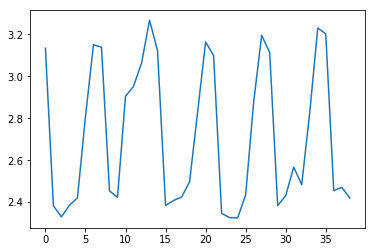

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.782308   
air_0164b9927d20bcc3_2017-04-23              1.416007   
air_0241aa3964b7f861_2017-04-23              2.389406   
air_0328696196e46f18_2017-04-23              2.095476   
air_034a3d5b40d5b1b1_2017-04-23              3.534587   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.943558  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.120634  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.907016  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.129311  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.280842

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l4_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')